In [1]:
import pickle

import numpy as np

from log_prob import log_prob

/Users/franceschi/mysims/DISKLAB/disklab/diskradial.py:18: UserWarning: numba not available, opacity calculation will be very slow
  warnings.warn('numba not available, opacity calculation will be very slow')


In [2]:
fname = "options.pickle"
with open(fname, "rb") as fb:
    options = pickle.load(fb)

ndim = 7

# param0 = 10 ** ((np.random.rand() - 0.5) * 4)
# param1 = np.random.rand(ndim - 3, 1)
# param2 = (np.random.rand() + 0.5) / 100
# param3 = (np.random.rand() - 0.5)
#
# p0 = np.vstack((param0, param1, param2, param3)).T[0]

p0 = [
    7.0,
    0.730,
    0.558,
    0.017,
    0.625,
    0.008,
    0.050,
]

/Users/franceschi/mysims/IMLup/refactoring/helper_functions.py:67: UserWarning: Disk mass is unreasonably high: M_disk / Mstar = 0.3
  warnings.warn(f'Disk mass is unreasonably high: M_disk / Mstar = {d.mass/mstar:.2g}')


disk to star mass ratio = 0.3


/Users/franceschi/mysims/DISKLAB/disklab/radmc3d/radmc3d_helper.py:821: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin=vmax - 8, vmax=vmax, edgecolor=(1, 1, 1, 0.5), linewidth=0.1)
/Users/franceschi/mysims/DISKLAB/disklab/radmc3d/radmc3d_helper.py:823: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin=vmax - 8, vmax=vmax, edgecolor=(1, 1, 1, 0.5), linewidth=0.1)
/Users/franceschi/mysims/DISKLAB/disklab/radmc3d/radmc3d_helper.py:910: MatplotlibDeprecatio

Reading runs/test_412010041/image.out
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
Reading runs/test_412010041/image_sca.out
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/anaconda3/envs/dipsy/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
is debugging on?
debugging on
runs/run_412010041.pickle


/Users/franceschi/mysims/IMLup/refactoring/log_prob.py:230: UserWarning: observed and simulated scattered radial profile grids are not equal
  warnings.warn(f"observed and simulated scattered radial profile grids are not equal")


-15.594914755722145

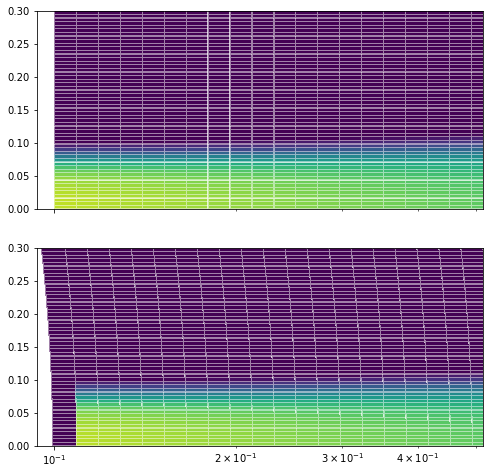

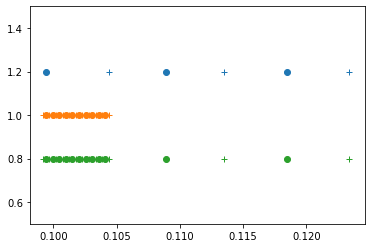

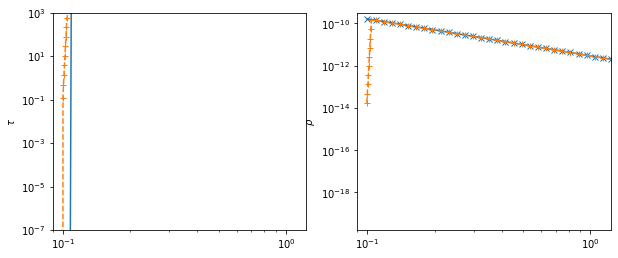

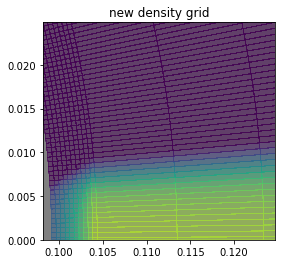

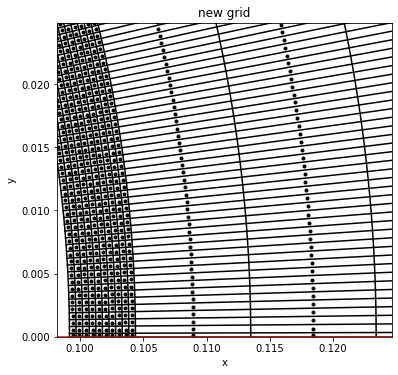

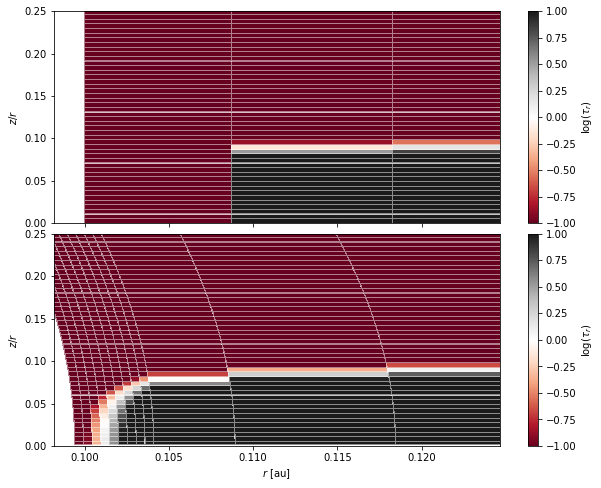

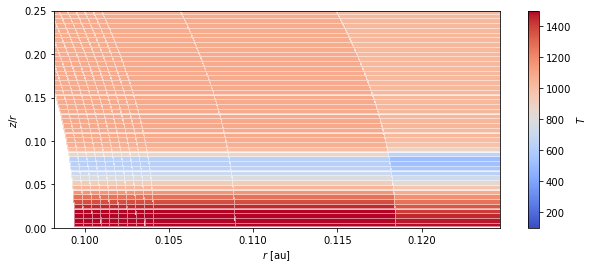

In [3]:
prob, blob = log_prob(p0, options, debugging=True)
prob

In [4]:
blob

3346853457